In [1]:
import medmnist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchio as tio
from torch.autograd import Variable


In [2]:
from medmnist import NoduleMNIST3D
dataset = NoduleMNIST3D(split='test',download=True)
print(dataset) 863

Using downloaded and verified file: C:\Users\veedu\.medmnist\nodulemnist3d.npz
Dataset NoduleMNIST3D of size 28 (nodulemnist3d)
    Number of datapoints: 310
    Root location: C:\Users\veedu\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    License:

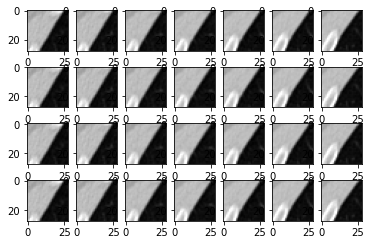

In [3]:
image=dataset[np.random.randint(len(dataset))][0] #
fig,ax = plt.subplots(4,7)
for i in range(4):
    for j in range(7):
        ax[i,j].imshow(image[0][j],cmap='gray')
plt.show()

In [79]:
data_flag = 'nodulemnist3d'
download = False

num_epochs = 20#no. of times the NN is trained on the entire dataset
batch_size = 64 #no. of images before parameters are updated
lr = 0.01

info = INFO[data_flag]
task = info['task'] #binary classification or multi-classification?
num_channels = info['n_channels'] #colour channels
num_classes = len(info['label']) #number of classes

DataClass = getattr(medmnist, info['python_class'])

In [5]:
transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.ZNormalization(),
])


train_data = DataClass(split='train', transform=transform,download=download)

count=0
for x,y in train_data:
    if y==[0]:
        count+=1
print(count/len(train_data))
    
    
test_data = DataClass(split='test', transform=transform,download=download)

train_loader = data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

0.7452504317789291


In [71]:
class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model= nn.Sequential(
        
        #Conv layer 1    
        nn.Conv3d(num_channels, 28, kernel_size=(3, 3, 3), padding=0),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),   
        
        #Conv layer 2  
        nn.Conv3d(28, 56, kernel_size=(3, 3, 3), padding=0),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),
               
        #Flatten
        nn.Flatten(),  
        #Linear 1
        nn.Linear(7000,28), 
        #Relu
        nn.ReLU(),
        #BatchNorm1d
        nn.BatchNorm1d(28),
        #Dropout
        nn.Dropout(p=0.15),
        #Linear 2
        nn.Linear(28, num_classes)
        )

    def forward(self, x):
        # Set 1
        out = self.model(x)
        return out

GPU Accelerated

In [80]:
import torch

# Check for available GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move model and tensors to GPU
model = Net().to(device)  # Move model to GPU
weight = torch.tensor([100,0.01]) #should be 0.6709,1.963
criterion = nn.CrossEntropyLoss(weight=weight).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

acc_array=np.zeros(num_epochs)
# Move data to GPU inside the loops
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Process target and outputs (on GPU)
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)  # convert to probability
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)  # targets
            y_score = torch.cat((y_score, outputs), 0)  # predicted output + probability

    y_true = y_true.cpu().numpy()  # Move data back to CPU for evaluation
    y_score = y_score.cpu().detach().numpy()

    evaluator = Evaluator(data_flag, 'test')
    auc, acc = evaluator.evaluate(y_score)
    acc_array[epoch] = acc

100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Text(0, 0.5, 'Acc')

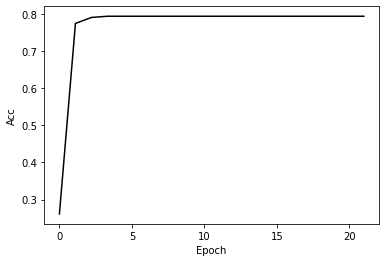

In [81]:
n=np.linspace(0,num_epochs+1,num_epochs)
plt.plot(n,acc_array,color='black')
plt.xlabel('Epoch')
plt.ylabel('Acc')